In [1]:
import os
import tensorflow as tf


print(os.path.isdir("/host/mask_rcnn"))



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


True


In [2]:

import os
print(os.listdir("/host/my_dataset_train"))

print(os.listdir("/host/my_dataset_val"))

['001.json', '001.png', '002.json', '002.png', '003.json', '003.png', '004.json', '004.png', '005.json', '005.png', '006.json', '006.png', '007.json', '007.png', '008.json', '008.png', '009.json', '009.png', '010.json', '010.png', '011.json', '011.png', '012.json', '012.png', '013.json', '013.png', '014.json', '014.png', '015.json', '015.png', '016.json', '016.png', '017.json', '017.png', '018.json', '018.png', '019.json', '019.png', '100.json', '100.png', '101.json', '101.png', '102.json', '102.png', '103.json', '103.png', '104.json', '104.png', '105.json', '105.png', '106.json', '106.png', '107.json', '107.png', '108.json', '108.png', '109.json', '109.png', '110.json', '110.png', '111.json', '111.png', '112.json', '112.png', '113.json', '113.png', '114.json', '114.png', '115.json', '115.png', '116.json', '116.png', '117.json', '117.png', '118.json', '118.png', '119.json', '119.png', '120.json', '120.png', '121.json', '121.png', '122.json', '122.png', '123.json', '123.png', '124.json'

In [3]:
# Importer les bibliothèques nécessaires
import os
import sys
import numpy as np
import mrcnn.model as modellib
import mrcnn.model as MaskRCNN
from mrcnn.config import Config
from mrcnn import utils

import json
import os
from pycocotools.coco import COCO

# Définir le chemin vers le modèle pré-entraîné
COCO_MODEL_PATH = "/host/mask_rcnn/mask_rcnn_coco.h5"

Using TensorFlow backend.


In [4]:
class CustomConfig(Config):
    NAME = "custom_model"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 classe pour ton objet
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.7
    LEARNING_RATE = 1e-3


In [5]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os
from mrcnn import utils

class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir):
        # Ajouter les classes (par exemple, une classe nommée "sword")
        self.add_class("dataset", 1, "sword")  # Remplace "sword" par le nom réel de ta classe

        # Parcourir les fichiers JSON pour associer chaque image à ses annotations
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".json"):
                json_path = os.path.join(dataset_dir, filename)
                
                # Charger le fichier JSON
                with open(json_path) as f:
                    data = json.load(f)

                # Obtenir le chemin de l'image correspondant
                image_filename = data['imagePath'].replace("\\", "/").split("/")[-1]
                image_path = os.path.join(dataset_dir, image_filename)

                # Vérifier si le fichier image existe
                if not os.path.exists(image_path):
                    print("Image non trouvée pour {}".format(filename))
                    continue
                
                # Ajouter l'image au dataset
                image_id = os.path.splitext(filename)[0]
                self.add_image(
                    "dataset",
                    image_id=image_id,
                    path=image_path,
                    width=data['imageWidth'],
                    height=data['imageHeight'],
                    polygons=data['shapes']  # Liste des polygones pour chaque objet
                )

    def load_mask(self, image_id):
        # Récupérer les informations de l'image
        image_info = self.image_info[image_id]
        polygons = image_info['polygons']

        # Créer un masque vide (hauteur, largeur, nombre de polygones)
        mask = np.zeros([image_info["height"], image_info["width"], len(polygons)], dtype=np.uint8)

        # Remplir le masque pour chaque polygone
        for i, shape in enumerate(polygons):
            # Convertir les points en tuples (x, y)
            polygon_points = [(int(x), int(y)) for x, y in shape['points']]
            img = Image.new('L', (image_info["width"], image_info["height"]), 0)
            ImageDraw.Draw(img).polygon(polygon_points, outline=1, fill=1)
            mask[:, :, i] = np.array(img)

        # Retourner les masques et les IDs de classe
        class_ids = np.array([1] * len(polygons), dtype=np.int32)  # Ajuste si tu as plusieurs classes
        return mask, class_ids



In [6]:
dataset_train = CustomDataset()
dataset_train.load_custom("/host/my_dataset_train")  # Plus besoin du paramètre "train"
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_custom("/host/my_dataset_val")  # Plus besoin du paramètre "val"
dataset_val.prepare()


In [7]:
# Créer la configuration
config = CustomConfig()

# Initialiser le modèle
model = modellib.MaskRCNN(mode="training", config=config, model_dir="logs/")

# Charger les poids COCO pré-entraînés
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


In [8]:
print("Informations des images d'entraînement :", dataset_train.image_info)
print("Informations des images de validation :", dataset_val.image_info)

Informations des images d'entraînement : [{'id': '001', 'polygons': [{'shape_type': 'polygon', 'group_id': None, 'points': [[118.7018779342723, 84.44131455399061], [123.39671361502347, 82.09389671361502], [129.03051643192487, 77.86854460093896], [147.34037558685446, 64.72300469483568], [163.06807511737088, 55.56807511737088], [177.8568075117371, 47.82159624413145], [185.13380281690138, 43.12676056338027], [193.11502347417837, 42.18779342723004], [195.69718309859155, 35.61502347417839], [201.33098591549293, 26.69483568075117], [208.84272300469485, 21.765258215962437], [219.1713615023474, 20.356807511737085], [225.74413145539904, 20.356807511737085], [231.612676056338, 24.8169014084507], [232.55164319248826, 30.685446009389665], [230.4389671361502, 35.38028169014083], [228.09154929577466, 44.300469483568065], [223.16197183098592, 49.69953051643192], [226.68309859154925, 52.516431924882625], [227.8568075117371, 56.27230046948356], [226.68309859154925, 61.67136150234741], [231.847417840375

In [9]:
print("Nombre d'images dans le dataset d'entraînement :", len(dataset_train.image_ids))
print("Nombre d'images dans le dataset de validation :", len(dataset_val.image_ids))


Nombre d'images dans le dataset d'entraînement : 135
Nombre d'images dans le dataset de validation : 15


In [10]:
model.train(
    dataset_train,                  # Dataset d'entraînement
    dataset_val,                    # Dataset de validation
    learning_rate=config.LEARNING_RATE,
    epochs=30,
    layers='heads'                  # Spécifiez les couches à entraîner
)


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/custom_model20241111T0045/mask_rcnn_custom_model_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
 99/100 [============================>.] - ETA: 14s - loss: 2.6455 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 1.3481 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.7040 - mrcnn_mask_loss: 0.4231

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 1510s 15s/step - loss: 2.6372 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.3511 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.6969 - mrcnn_mask_loss: 0.4189 - val_loss: 1.7631 - val_rpn_class_loss: 0.0259 - val_rpn_bbox_loss: 0.6129 - val_mrcnn_class_loss: 0.0788 - val_mrcnn_bbox_loss: 0.8022 - val_mrcnn_mask_loss: 0.2433
Epoch 2/30
100/100 [==============================] - 1482s 15s/step - loss: 1.5826 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.5857 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.5836 - mrcnn_mask_loss: 0.3002 - val_loss: 1.2970 - val_rpn_class_loss: 0.0227 - val_rpn_bbox_loss: 0.4257 - val_mrcnn_class_loss: 0.0525 - val_mrcnn_bbox_loss: 0.5903 - val_mrcnn_mask_loss: 0.2059
Epoch 3/30
100/100 [==============================] - 1482s 15s/step - loss: 1.5717 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6831 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.2857 - val_loss: 1.2011 - val_rpn_class_loss: 

Epoch 23/30
100/100 [==============================] - 1508s 15s/step - loss: 0.6367 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1744 - val_loss: 1.2802 - val_rpn_class_loss: 0.0183 - val_rpn_bbox_loss: 0.6248 - val_mrcnn_class_loss: 0.0719 - val_mrcnn_bbox_loss: 0.3711 - val_mrcnn_mask_loss: 0.1940
Epoch 24/30
100/100 [==============================] - 1522s 15s/step - loss: 0.5813 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2618 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1474 - val_loss: 1.1329 - val_rpn_class_loss: 0.0152 - val_rpn_bbox_loss: 0.5420 - val_mrcnn_class_loss: 0.0591 - val_mrcnn_bbox_loss: 0.3305 - val_mrcnn_mask_loss: 0.1860
Epoch 25/30
100/100 [==============================] - 1513s 15s/step - loss: 0.5599 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1704 - val_loss: 1.3007 - val_rp

Exemples du Dataset d'Entraînement


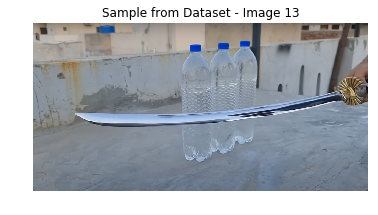

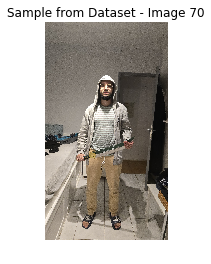

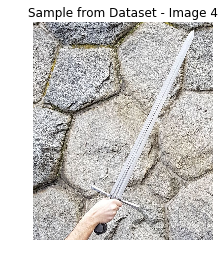

Exemples du Dataset de Validation


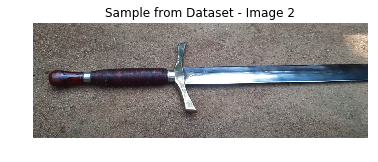

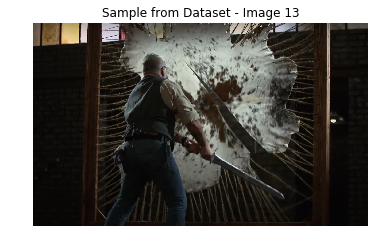

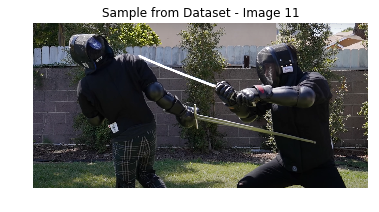

In [12]:
import matplotlib.pyplot as plt
import random

def display_sample(dataset, count=3):
    """Affiche un échantillon d'images du dataset."""
    for i in range(count):
        image_id = random.choice(dataset.image_ids)
        image = dataset.load_image(image_id)
        plt.imshow(image)
        plt.title("Sample from Dataset - Image {}".format(image_id))
        plt.axis("off")
        plt.show()

# Affichez 3 images du dataset d'entraînement et de validation
print("Exemples du Dataset d'Entraînement")
display_sample(dataset_train)
print("Exemples du Dataset de Validation")
display_sample(dataset_val)
